### Helper Methods for getting data

- The functions are described in their corresponding docstring 
- Each serving a different purpose to get or extract different types of data

In [1]:
from time import sleep
import pandas as pd
import numpy as np
import jikanpy as jikan
from collections import Counter

jikan = jikan.Jikan()


def get_anime_data(anime_id):
    """
    Gets the data for a given anime id
    Parameters:
    anime_id: int

    Returns:
    df: DataFrame with anime data
    """
    anime = jikan.anime(anime_id)
    df = pd.DataFrame.from_dict(anime)
    return df


def get_popular_anime():
    """
    Gets the popular anime from the Jikan API / MAL Database

    Returns:
    popular_anime: Dict containting the popular anime from the first page (25 entries)
    """
    popular_anime = jikan.top(type="anime", parameters={"filter": "bypopularity"})
    return popular_anime


def get_top_manga():
    """
    Gets the top current manga from the Jikan API / MAL Database

    Returns:
    top_manga: Dict containting the top manga from the first page (25 entries)
    """
    sleep(1)
    top_manga = jikan.top(type="manga")
    return top_manga


def get_top_manga_pagination(num_pages=2):
    """
    Gets the top current manga from the Jikan API / MAL Database in the range of requested pages

    Parameters:
    num_pages: int, default 2 -> leads to the first 2 pages being scraped
    
    Returns:
    top_manga: DataFrame containting the top anime from the first page (25 entries)
    """ """"""
    top_manga = pd.DataFrame()
    for i in range(1, num_pages + 1):
        top_manga_current_page = pd.DataFrame(jikan.top(type="manga", page=i)["data"])
        sleep(2)  # to prevent rate limiting
        top_manga = pd.concat([top_manga, top_manga_current_page], ignore_index=True)
    return top_manga


def get_top_anime():
    """
    Gets the top current anime from the Jikan API / MAL Database

    Returns:
    top_anime: Dict containting the top anime from the first page (25 entries)
    """ """"""
    sleep(1)
    top_anime = jikan.top(type="anime")
    return top_anime

def get_top_anime_pagination(num_pages=2):
    """
    Gets the top current anime from the Jikan API / MAL Database in the range of requested pages

    Parameters:
    num_pages: int, default 2 -> leads to the first 2 pages being scraped
    
    Returns:
    top_anime: DataFrame containting the top anime from the first page (25 entries)
    """ """"""
    top_anime = pd.DataFrame()
    for i in range(1, num_pages + 1):
        top_anime_current_page = pd.DataFrame(jikan.top(type="anime", page=i)["data"])
        sleep(2)  # to prevent rate limiting
        top_anime = pd.concat([top_anime, top_anime_current_page], ignore_index=True)
    return top_anime


def get_top_anime_equivalent_manga_scores():
    """
    Gets the top anime and their equivalent manga scores
    
    Returns:
    top_anime_scorings: list of top anime scores
    manga_scorings: list of equivalent manga scores
    """
    top_anime = pd.DataFrame(jikan.top(type="anime")["data"])[0:10]
    top_anime_scorings = top_anime["score"].tolist()
    mal_ids = top_anime["mal_id"]
    manga_scorings = []
    for i in range(0, len(mal_ids)):
        current = jikan.anime(mal_ids[i], extension="relations")
        current = pd.DataFrame(current["data"])
        index = current.loc[current["relation"] == "Adaptation"].index[0]
        entry = current["entry"][index]
        manga_id = entry[0]["mal_id"]
        manga = jikan.manga(manga_id)
        sleep(2)
        manga_scorings.append(manga["data"]["score"])
    return top_anime_scorings, manga_scorings


def get_top_manga_equivalent_anime_scores():
    top_manga = pd.DataFrame(jikan.top(type="manga")["data"])[0:10]
    sleep(2)
    top_manga_scorings = top_manga["score"].tolist()
    mal_ids = top_manga["mal_id"]
    anime_scorings = []
    for i in range(0, len(mal_ids)):
        sleep(2)
        current = jikan.manga(mal_ids[i], extension="relations")
        current = current["data"]
        if current == []:
            anime_scorings.append(np.nan)
            continue
        current = pd.DataFrame(current)
        index = current.loc[current["relation"] == "Adaptation"].index
        if index.empty:
            anime_scorings.append(np.nan)
            continue
        entry = current["entry"][index[0]]
        anime_id = entry[0]["mal_id"]
        anime = jikan.anime(anime_id)
        anime_scorings.append(anime["data"]["score"])
    return top_manga_scorings, anime_scorings


def extract_top_anime_names(top_anime):
    """
    Extracts the names of the top anime from the top anime data

    Parameters:
    top_anime: dict

    Returns:
    df: DataFrame with anime names
    """
    df = pd.DataFrame(top_anime["data"])["title_english"]
    return df


def extract_top_manga_names(top_manga):
    """
    Extracts the names of the top manga from the top manga data

    Parameters:
    top_anime: dict

    Returns:
    df: DataFrame with anime names
    """
    df = pd.DataFrame(top_manga["data"])["title"]
    return df


def extract_top_manga_scoring(top_manga):
    """
    Extracts the names of the top manga from the top manga data

    Parameters:
    top_anime: dict

    Returns:
    df: DataFrame with anime names
    """
    df = pd.DataFrame(top_manga["data"])["score"]
    return df


def extract_top_anime_scoring(top_anime):
    """
    Extracts the scores of the top anime from the top anime data

    Parameters:
    top_anime: dict

    Returns:
    df: DataFrame with anime scores
    """
    df = pd.DataFrame(top_anime["data"])["score"]
    return df


def return_top_anime_top_manga_with_score(amount=10):
    """
    Returns a DataFrame with the top anime and manga with their respective scores

    Parameters:
    amount: int, default 10

    Returns:
    df: DataFrame with top anime and manga with scores
    """
    top_anime = get_top_anime()
    top_manga = get_top_manga()
    df = pd.DataFrame()
    top_anime_names = extract_top_anime_names(top_anime)[0:amount]
    top_anime_scores = extract_top_anime_scoring(top_anime)[0:amount]
    top_manga_names = extract_top_manga_names(top_manga)[0:amount]
    top_manga_scores = extract_top_manga_scoring(top_manga)[0:amount]
    df = pd.concat(
        [top_anime_names, top_anime_scores, top_manga_names, top_manga_scores], axis=1
    )
    df.columns = ["Top Anime", "Top Anime Score", "Top Manga", "Top Manga Score"]
    return df


def get_review_texts(anime_id, num_pages=5):
    """
    Gets the review texts for a given anime id

    Parameters:
    anime_id: int
    num_pages: int, default 5 pages

    Returns:
    df: DataFrame with review texts
    """
    df = pd.DataFrame()
    for i in range(1, num_pages):
        review = jikan.anime(anime_id, extension="reviews", page=i)
        if review["data"] == []:
            break  # data equals empty list if there are no more reviews
        else:
            sleep(2)  # to prevent rate limiting
        new_data = pd.DataFrame.from_dict(review["data"])["review"]
        df = pd.concat([df, new_data], ignore_index=True)
    return df


def get_top_popular_demographics():
    num_pages = 10
    demographic_names_popular = []
    demographic_names_top = []
    total_titles = 0
    for i in range(1, num_pages):
        top_anime = pd.DataFrame(jikan.top(type="anime", page=i)["data"])
        sleep(2)  # to prevent rate limiting
        popular_anime = pd.DataFrame(
            jikan.top(type="anime", parameters={"filter": "bypopularity"}, page=i)[
                "data"
            ]
        )

        # getting demographics dicts, which are in a list
        top_anime_demographics = top_anime["demographics"]
        popular_anime_demographics = popular_anime["demographics"]

        # extracting list item, then extracting name from dict
        demographic_names_top = demographic_names_top + [
            x["name"] for item in top_anime_demographics for x in item
        ]
        demographic_names_popular = demographic_names_popular + [
            x["name"] for item in popular_anime_demographics for x in item
        ]
        total_titles += len(top_anime_demographics) + len(popular_anime_demographics)

    return (
        Counter(demographic_names_top),
        Counter(demographic_names_popular),
        total_titles,
    )


def get_top_popular_genres():
    num_pages = 10
    genre_names_popular = []
    genre_names_top = []
    total_titles = 0
    for i in range(1, num_pages):
        top_anime = pd.DataFrame(jikan.top(type="anime", page=i)["data"])
        # to prevent rate limiting
        sleep(2)
        popular_anime = pd.DataFrame(
            jikan.top(type="anime", parameters={"filter": "bypopularity"}, page=i)[
                "data"
            ]
        )
        # getting genres dicts, which are in a list
        top_anime_genres = top_anime["genres"]
        popular_anime_genres = popular_anime["genres"]

        # extracting list item, then extracting name from dict
        genre_names_top = genre_names_top + [
            x["name"] for item in top_anime_genres for x in item
        ]
        genre_names_popular = genre_names_popular + [
            x["name"] for item in popular_anime_genres for x in item
        ]
        total_titles += len(top_anime_genres) + len(popular_anime_genres)

    return (
        Counter(genre_names_top),
        Counter(genre_names_popular),
        total_titles,
    )

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use("seaborn-v0_8-paper")

blue_color = "#1f77b4"
orange_color = "#ff7f0e"

#### Getting the top 10 Anime and Manga with score
Plotting the scores of each rank grouped by the type of media they are

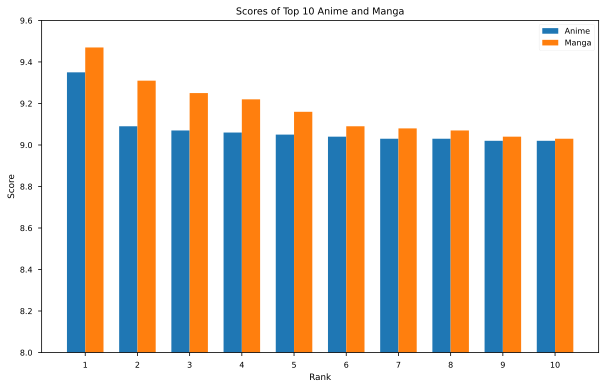

In [18]:
df_top_animanga = return_top_anime_top_manga_with_score(10)

# Assuming df_top_animanga is a DataFrame with columns 'anime_score' and 'manga_score'
anime_scores = df_top_animanga["Top Anime Score"]
manga_scores = df_top_animanga["Top Manga Score"]
anime_titles = df_top_animanga["Top Anime"]
manga_titles = df_top_animanga["Top Manga"]

# Create an array with the positions of each bar along the x-axis
x = np.arange(len(anime_scores))

# Create fig
plt.figure(figsize=(10, 6))

# Create the bar chart
bar_width = 0.35
plt.bar(x - bar_width / 2, anime_scores, bar_width, label="Anime", color=blue_color)
plt.bar(x + bar_width / 2, manga_scores, bar_width, label="Manga", color=orange_color)

# Add title and labels
plt.title("Scores of Top 10 Anime and Manga")
plt.xlabel("Rank")
plt.ylabel("Score")
plt.xticks(x, range(1, len(anime_scores) + 1))  # Set x-tick labels to start from 1

# Add a legend
plt.legend()

# Set y-axis limit
plt.ylim(8, 9.6)

# Show the plot
plt.savefig("top_scores_bar.png", dpi=400)
plt.show()

#### Getting the mean of the top X manga and anime scores
Checking for top 10, top 25 and top 50 to see if the mean changes for each type of media  
-> it stays relatively consistent, that manga are overall rated better

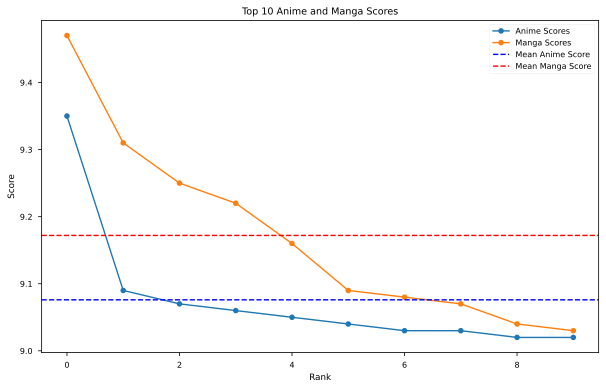

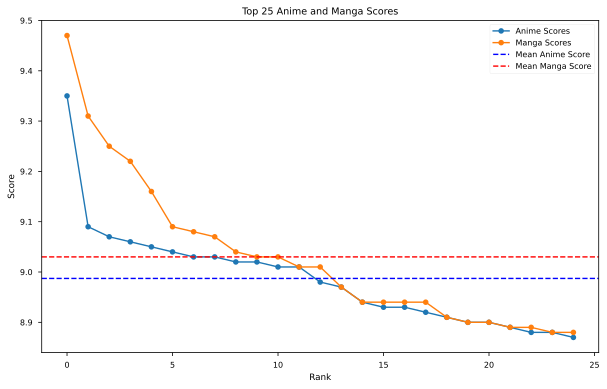

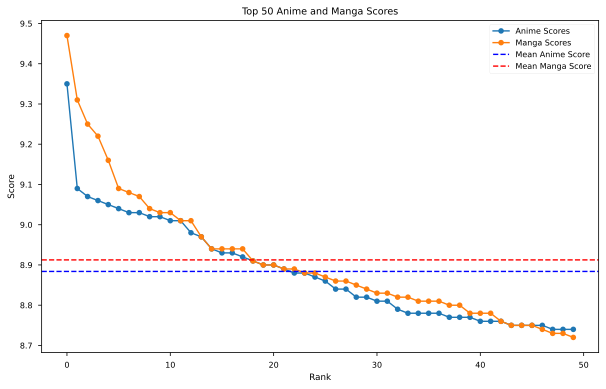

In [20]:
# Extract the top anime and manga scores
# Top 10
series_anime_scores10 = extract_top_anime_scoring(get_top_anime())[0:10]
series_manga_scores10 = extract_top_manga_scoring(get_top_manga())[0:10]
# Top 25
series_anime_scores25 = extract_top_anime_scoring(get_top_anime())[0:25]
series_manga_scores25 = extract_top_manga_scoring(get_top_manga())[0:25]
# Top 50
series_anime_scores50 = get_top_anime_pagination(2)["score"]
series_manga_scores50 = get_top_manga_pagination(2)["score"]

# Calculate the mean scores
mean_anime_score10 = series_anime_scores10.mean()
mean_manga_score10 = series_manga_scores10.mean()
mean_anime_score25 = series_anime_scores25.mean()
mean_manga_score25 = series_manga_scores25.mean()
mean_anime_score50 = series_anime_scores50.mean()
mean_manga_score50 = series_manga_scores50.mean()

def line_plot_scores(series_anime_scores, series_manga_scores, mean_anime_score, mean_manga_score, title):
    """
    Plots the scores of the top anime and manga as a line plot

    Parameters:
    series_anime_scores: Series with anime scores
    series_manga_scores: Series with manga scores
    mean_anime_score: float
    mean_manga_score: float
    title: str
    """
    # Create a new figure
    fig = plt.figure(figsize=(10, 6))

    # Plot the individual scores
    plt.plot(series_anime_scores, marker="o", label="Anime Scores")
    plt.plot(series_manga_scores, marker="o", label="Manga Scores")

    # Add the mean scores as straight lines horizontal to x axis
    plt.axhline(y=mean_anime_score, color="b", linestyle="--", label="Mean Anime Score")
    plt.axhline(y=mean_manga_score, color="r", linestyle="--", label="Mean Manga Score")

    # Add a legend
    plt.legend()

    # Add title and labels
    plt.title(title)
    plt.xlabel("Rank")
    plt.ylabel("Score")

    # Show the plot
    plt.savefig(f"scores_with{len(series_anime_scores)}_line.png", dpi=400)
    plt.show()

line_plot_scores(series_anime_scores10, series_manga_scores10, mean_anime_score10, mean_manga_score10, "Top 10 Anime and Manga Scores")
line_plot_scores(series_anime_scores25, series_manga_scores25, mean_anime_score25, mean_manga_score25, "Top 25 Anime and Manga Scores")
line_plot_scores(series_anime_scores50, series_manga_scores50, mean_anime_score50, mean_manga_score50, "Top 50 Anime and Manga Scores")

#### Are there more ratings on manga as compared to anime? (Mean value)
Looking at the top ten scored_by count and calculating the mean for the titles  
-> Manga are rated less, but still have a better overall score

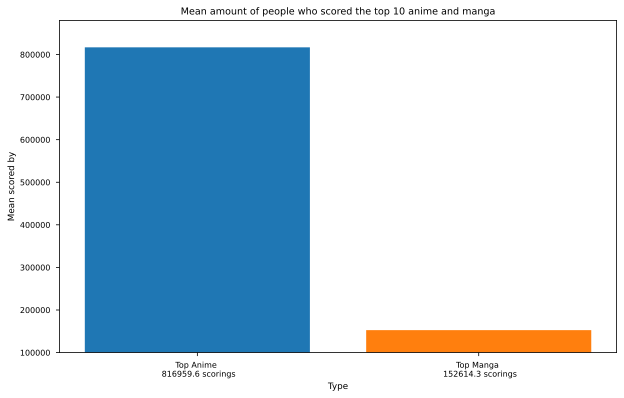

In [21]:
top_anime = pd.DataFrame(get_top_anime()["data"][0:10])["scored_by"].mean()
top_manga = pd.DataFrame(get_top_manga()["data"][0:10])["scored_by"].mean()

# Plot the scores
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# Create a new figure
plt.style.use("seaborn-v0_8-paper")
fig = plt.figure(figsize=(10, 6))

plt.title("Mean amount of people who scored the top 10 anime and manga")
plt.xlabel("Type")
plt.ylabel("Mean scored by")
plt.bar([f"Top Anime \n {top_anime} scorings", f"Top Manga \n {top_manga} scorings"], [top_anime, top_manga], color=[blue_color, orange_color])
plt.ylim(100000, 880000)

plt.savefig("top_scores_mean_scored_by.png", dpi=400)
plt.show()

#### Comparing Manga and Anime scoring of a title
The top 10 anime are rated better than their manga original source, however its the opposite for the top 10 manga. The anime adaptation are either rated significantly worse, or there aren't even adaptations

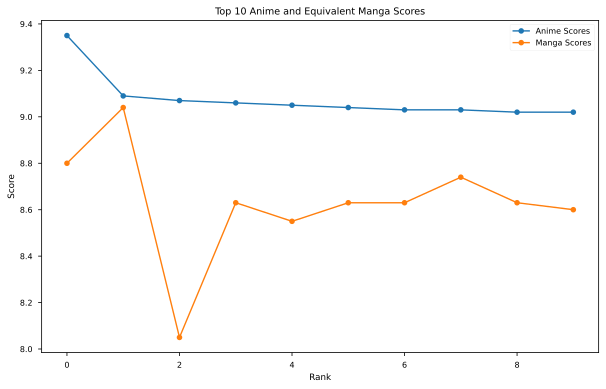

In [22]:
anime_scores, manga_scores = get_top_anime_equivalent_manga_scores()

# Create a new figure
fig = plt.figure(figsize=(10, 6))

# Plot the individual scores
plt.plot(anime_scores, marker="o", label="Anime Scores")
plt.plot(manga_scores, marker="o", label="Manga Scores")

# Add a legend
plt.legend()

# Add title and labels
plt.title("Top 10 Anime and Equivalent Manga Scores")
plt.xlabel("Rank")
plt.ylabel("Score")

# Show the plot
plt.savefig("top_anime_equivalent_manga_score.png", dpi=400)
plt.show()

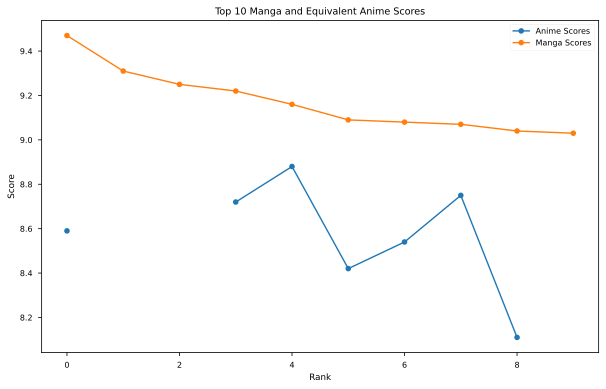

In [17]:
manga_scores, anime_scores = get_top_manga_equivalent_anime_scores()

# Create a new figure
fig = plt.figure(figsize=(10, 6))

# Plot the individual scores
plt.plot(anime_scores, marker="o", label="Anime Scores")
plt.plot(manga_scores, marker="o", label="Manga Scores")

# Add a legend
plt.legend()

# Add title and labels
plt.title("Top 10 Manga and Equivalent Anime Scores")
plt.xlabel("Rank")
plt.ylabel("Score")

# Show the plot
plt.savefig("top_manga_equivalent_anime_scores.png", dpi=400)
plt.show()

### Popularity vs scoring

In [24]:
top_anime = get_top_anime()
popular_anime = get_popular_anime()

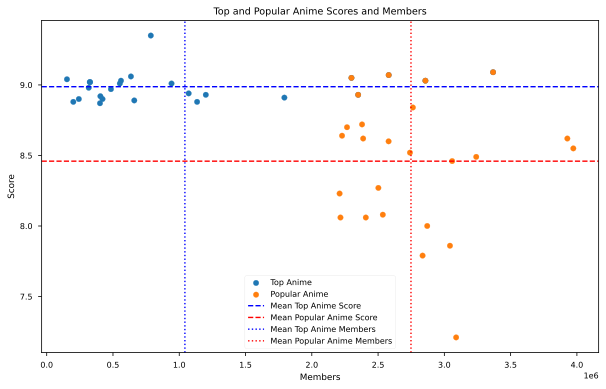

In [25]:
pop_members = []
pop_score = []
top_members = []
top_score = []

for i in range(len(top_anime["data"])):
    pop_members.append(popular_anime["data"][i]["members"])
    pop_score.append(popular_anime["data"][i]["score"])
    top_members.append(top_anime["data"][i]["members"])
    top_score.append(top_anime["data"][i]["score"])

# Create a new figure
fig = plt.figure(figsize=(10, 6))

# Plot the individual scores
plt.scatter(top_members, top_score, label="Top Anime")
plt.scatter(pop_members, pop_score, label="Popular Anime")

plt.axhline(y=sum(top_score) / len(top_score), color="b", linestyle="--", label="Mean Top Anime Score")
plt.axhline(y=sum(pop_score) / len(pop_score), color="r", linestyle="--", label="Mean Popular Anime Score")

plt.axvline(x=sum(top_members) / len(top_members), color="b", linestyle=":", label="Mean Top Anime Members")
plt.axvline(x=sum(pop_members) / len(pop_members), color="r", linestyle=":", label="Mean Popular Anime Members")

# Add a legend
plt.legend()

# Add title and labels
plt.title("Top and Popular Anime Scores and Members")
plt.xlabel("Members")
plt.ylabel("Score")

# Show the plot
plt.savefig("top_popular_anime_scores_members.png", dpi=400)
plt.show()

#### Machine Learning: Sentiment Analysis

In [76]:
df = get_review_texts(5114, 3)
df

,0
0,"First of all, I have seen the original FMA and..."
1,Fullmetal Alchemist: Brotherhood gets an immen...
2,Adaptations have long been a thorn in the side...
3,Since I couldn't find any legitimate objective...
4,*Spoiler Warning Aside from the usual everyday...
5,I can't even watch the original FMA anime now ...
6,"Now, this is a prime example of how to adapt a..."
7,"""We're not gods, we're only human. We can't ev..."
8,"If one wishes to obtain something, something o..."
9,Full metal alchemist brotherhood the anime tha...


#### Popular demographics (age groups / gender) and genres
Shonen - Teenagers, "young boy"  
Seinen - Young adult  
Shoujou - Female  

In [26]:
counts_top, counts_popular, total = get_top_popular_demographics()

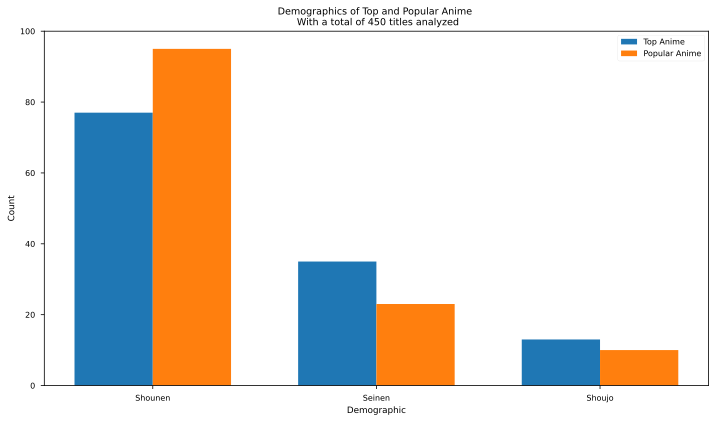

In [27]:
fig = plt.figure(figsize=(10, 6))

top = pd.DataFrame(counts_top.items(), columns=["demographic", "count"])[0:3]
popular = pd.DataFrame(counts_popular.items(), columns=["demographic", "count"])

n_groups = len(top)
index = np.arange(n_groups)
bar_width = 0.35

plt.bar(index, top["count"], bar_width, color=blue_color, label="Top Anime")
plt.bar(index + bar_width, popular["count"], bar_width, color=orange_color, label="Popular Anime")
plt.xlabel("Demographic")
plt.ylabel("Count")
plt.xticks(index + bar_width / 2, top["demographic"])
plt.title(
    f"Demographics of Top and Popular Anime \n With a total of {total} titles analyzed"
)
plt.tight_layout()
plt.ylim(0, 100)
plt.legend()
plt.show()

In [28]:
counts_top_genre, counts_popular_genre, total = get_top_popular_genres()

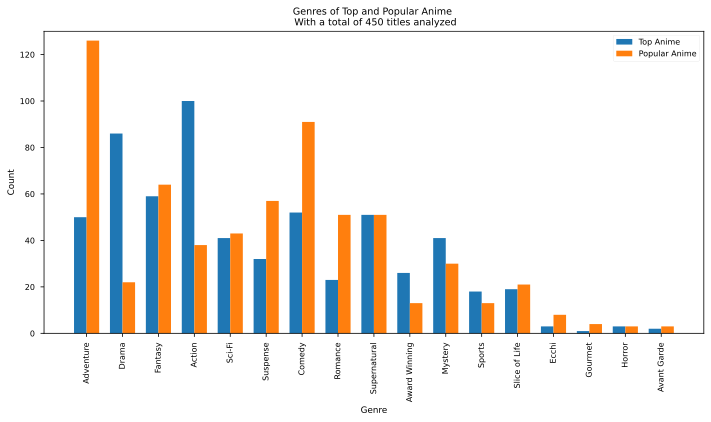

In [29]:
fig = plt.figure(figsize=(10, 6))

top = pd.DataFrame(counts_top_genre.items(), columns=["genre", "count"])
popular = pd.DataFrame(counts_popular_genre.items(), columns=["genre", "count"])

n_groups = len(top)
index = np.arange(n_groups)
bar_width = 0.35

plt.bar(index, top["count"], bar_width, color=blue_color, label="Top Anime")
plt.bar(
    index + bar_width,
    popular["count"],
    bar_width,
    color=orange_color,
    label="Popular Anime",
)

plt.xlabel("Genre")
plt.ylabel("Count")
plt.title(f"Genres of Top and Popular Anime \n With a total of {total} titles analyzed")
plt.xticks(index + bar_width / 2, top["genre"], rotation=90)
plt.legend()
plt.tight_layout()
plt.ylim(0, 130)
plt.show()